In [19]:
from google.colab import files
uploaded = files.upload()

Saving hockney.jpg to hockney.jpg
Saving content.jpg to content (2).jpg


In [20]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'
        .format(name=fn, length=len(uploaded[fn])))

User uploaded file "hockney.jpg" with length 112691 bytes
User uploaded file "content.jpg" with length 703351 bytes


In [0]:
import io

style_path = io.BytesIO(uploaded['hockney.jpg'])
content_path = io.BytesIO(uploaded['content.jpg'])

In [22]:
!pip3 install torch torchvision

In [0]:
%matplotlib inline

import torch
import torch.optim as optim
from torchvision import transforms, models

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# we need only 'features' part and do not need the 'classifier' part
vgg = models.vgg19(pretrained = True).features.eval()

for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_image(path, max_size = 400, shape = None):
    ''' Load and transform image and make sure the image <= 400
    pixels in the x-y dims. '''

    image = Image.open(path).convert('RGB')

    size = max_size if (max(image.size) > max_size) else max(image.size)

    if shape is not None:
        size = shape


    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                            (0.229, 0.224, 0.225))
    ])

    # discard the transparent, alpha channel(:3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image

In [0]:
# load content and style
content = load_image(content_path).to(device)
# resize style to match content
style = load_image(style_path, shape = content.shape[-2:]).to(device)

In [0]:
def im_convert(tensor):
  
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0) # B G R
    # undo normalizations
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) 
    image = image.clip(0, 1)

    return image

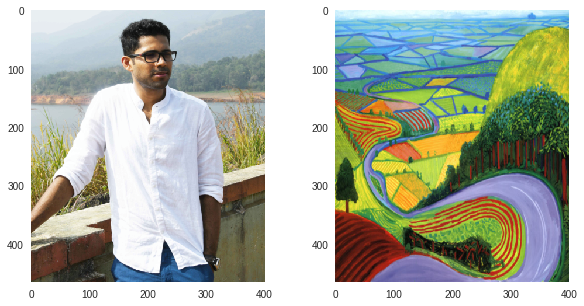

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.grid(False)
ax1.imshow(im_convert(content))
ax2.grid(False)
ax2.imshow(im_convert(style))

In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
          a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    if layers is None:
        layers = {
            '0':'conv1_1',
            '5':'conv2_1',
            '10':'conv3_1',
            '19':'conv4_1',
            '21':'conv4_2',
            '28':'conv5_1'
        }

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [0]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """

    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()

    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)

    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram

In [0]:
# get content and style features
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# get the gram matrices
style_grams = {layer : gram_matrix(style_features[layer]) for layer in style_features}

# get the target image
target = content.clone().requires_grad_(True).to(device)

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  37829148.0


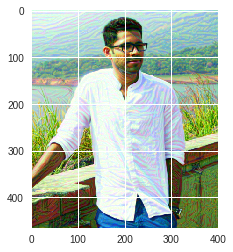

Total loss:  15028882.0


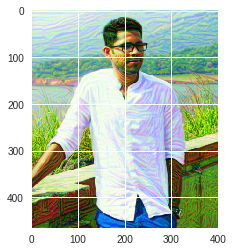

Total loss:  9187752.0


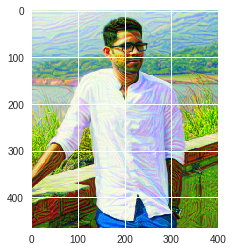

Total loss:  6388383.5


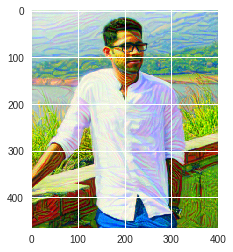

Total loss:  4669215.5


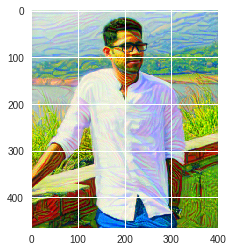

In [34]:
# constants
content_layer = 'conv4_2'

# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features[content_layer] - content_features[content_layer])**2)

    style_loss = 0

    for layer, weight in style_weights.items():

        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)

        style_gram = gram_matrix(style_features[layer])

        layer_loss = weight * torch.mean((target_gram - style_gram)**2)

        _, d, h, w = target_feature.shape

        style_loss += layer_loss / (d * h * w)


    total_loss = content_weight * content_loss + style_weight * style_loss

    # update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

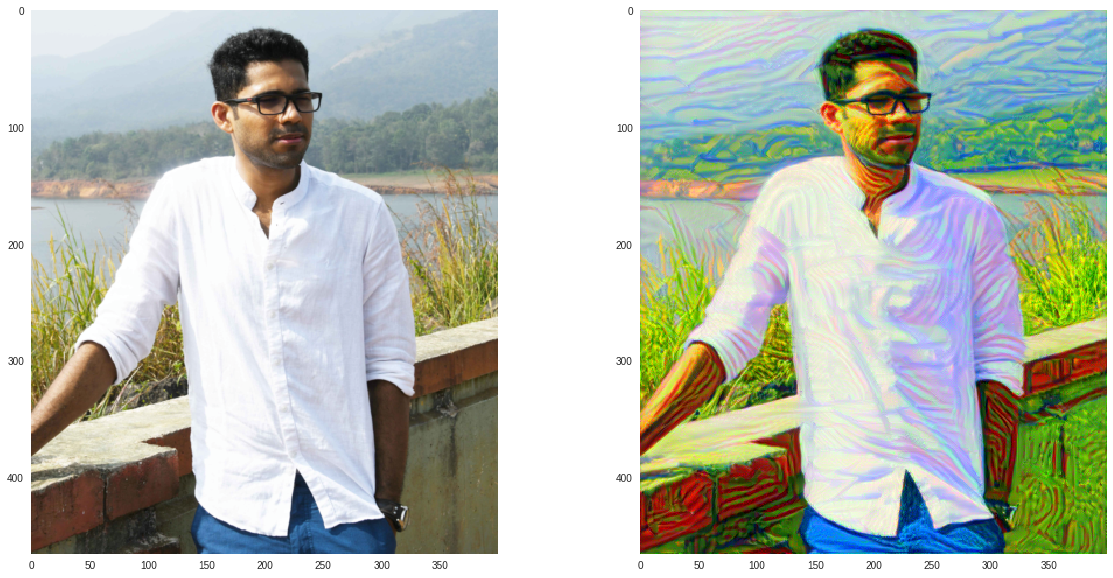

In [35]:
# display content and target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.grid(False)
ax1.imshow(im_convert(content))
ax2.grid(False)
ax2.imshow(im_convert(target))